# Logistic Regression

In this notebook, I revisit machine learning classification problems. However, in previous binary classification problems, such as in the Perceptron model notebook, I assumed that the data was linearly separable. However, the two figures generated by running the following code show that much of the palmer_penguins dataset is not linearly separable. Even though they're not linearly separable, I'm still going to give you another penguin fun fact: All Penguins Live in the Southern Hemisphere. (Actually this one is kinda a sad fact since I live in the Northern Hemisphere.)

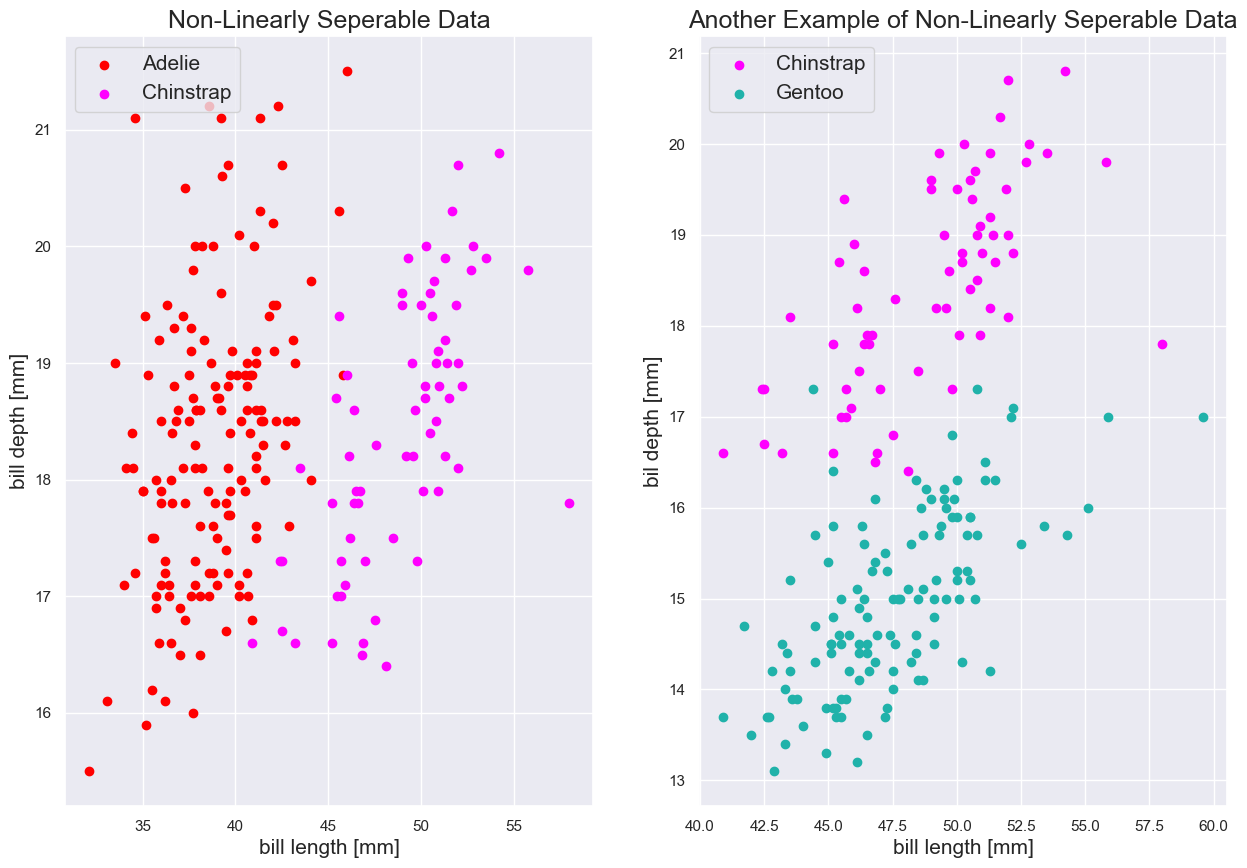

In [1]:
# import the necessary libraries and a function for plotting decision boundaries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Read the palmer_penguins dataset into a pandas DataFrame object
df = pd.read_csv("Datasets/palmer_penguins.csv")

Adelie = df[df.species == "Adelie"]
Chinstrap = df[df.species == "Chinstrap"]
Gentoo = df[df.species == "Gentoo"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.scatter(Adelie.bill_length_mm, Adelie.bill_depth_mm, color = "red", label = "Adelie")
ax1.scatter(Chinstrap.bill_length_mm, Chinstrap.bill_depth_mm, color = "magenta", label = "Chinstrap")
ax1.set_xlabel("bill length [mm]", fontsize = 15)
ax1.set_ylabel("bill depth [mm]", fontsize = 15)
ax1.legend(fontsize = 15, loc = "upper left")
ax1.set_title("Non-Linearly Seperable Data", fontsize = 18)


ax2.scatter(Chinstrap.bill_length_mm, Chinstrap.bill_depth_mm, color = "magenta", label = "Chinstrap")
ax2.scatter(Gentoo.bill_length_mm, Gentoo.bill_depth_mm, color = "lightseagreen", label = "Gentoo")
ax2.set_xlabel("bill length [mm]", fontsize = 15)
ax2.set_ylabel("bil depth [mm]", fontsize = 15)
ax2.legend(fontsize = 15, loc = "upper left")
ax2.set_title("Another Example of Non-Linearly Seperable Data", fontsize = 18)
plt.show()

As seen in the figures generated above, it is impossible to split the species of penguins by any linear function since they overlap in the same regions of space. If we were training a Perceptron single neuron with overlapping data, it would never converge and keep running forever if there wasn't a time limit on it.

However, notice that in the non-linearly separable case, the probability of selecting a Chinstrap penguin is higher than the probability of selecting a Gentoo penguin whenever bill depth is greater than 16.6. Conversely, the probability of selecting a Gentoo penguin is higher than the probability of selecting a Chinstrap penguin whenever the bill depth is less than 16.6. 

Observing this, label each Chinstrap flower by 0 and each Gentoo flower by 1.

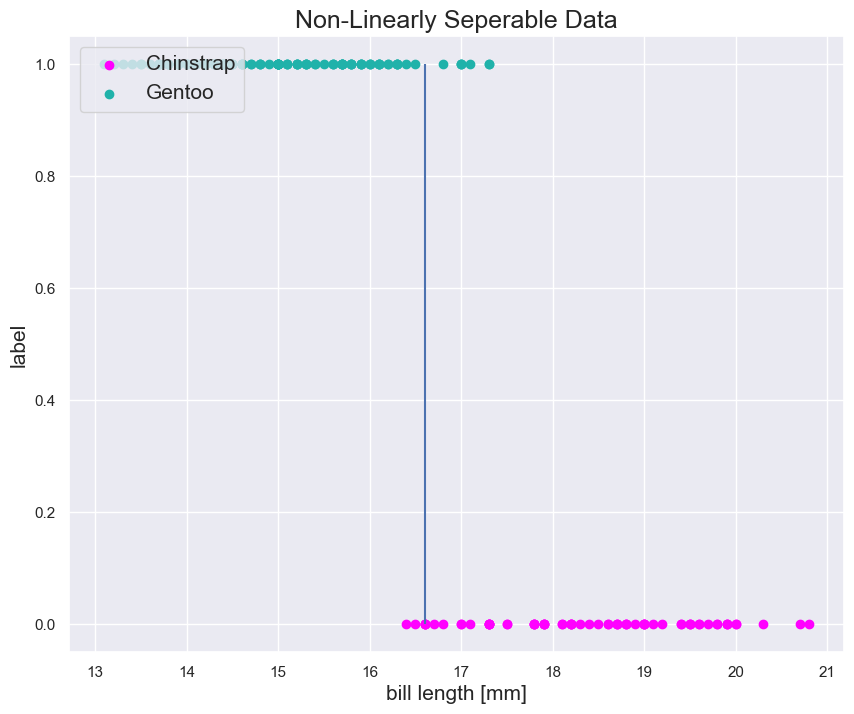

In [2]:
plt.figure(figsize = (10, 8))
plt.scatter(Chinstrap.bill_depth_mm, np.zeros(68), color = "magenta", label = "Chinstrap")
plt.scatter(Gentoo.bill_depth_mm, np.ones(123), color = "lightseagreen", label = "Gentoo")
plt.vlines(16.6, 0.0, 1.0)
plt.xlabel("bill length [mm]", fontsize = 15)
plt.ylabel("label", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.title("Non-Linearly Seperable Data", fontsize = 18)
plt.show()

As before (both with the Perceptron and Linear Regression single neurons), an activation function has to be decided on before deciding on a cost/loss function. The *sigmoid* activation function is used in this implementation:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

This differentiable function has a range in $(0, 1)$, so it would seem suitable for a possible function to turn the pre-activation value into a value representing a probability. Moreover, the sigmoid function has a smooth "S"-shape that is perfect for probabilities values transitioning, either growing or shrinking, as the input feature changes.

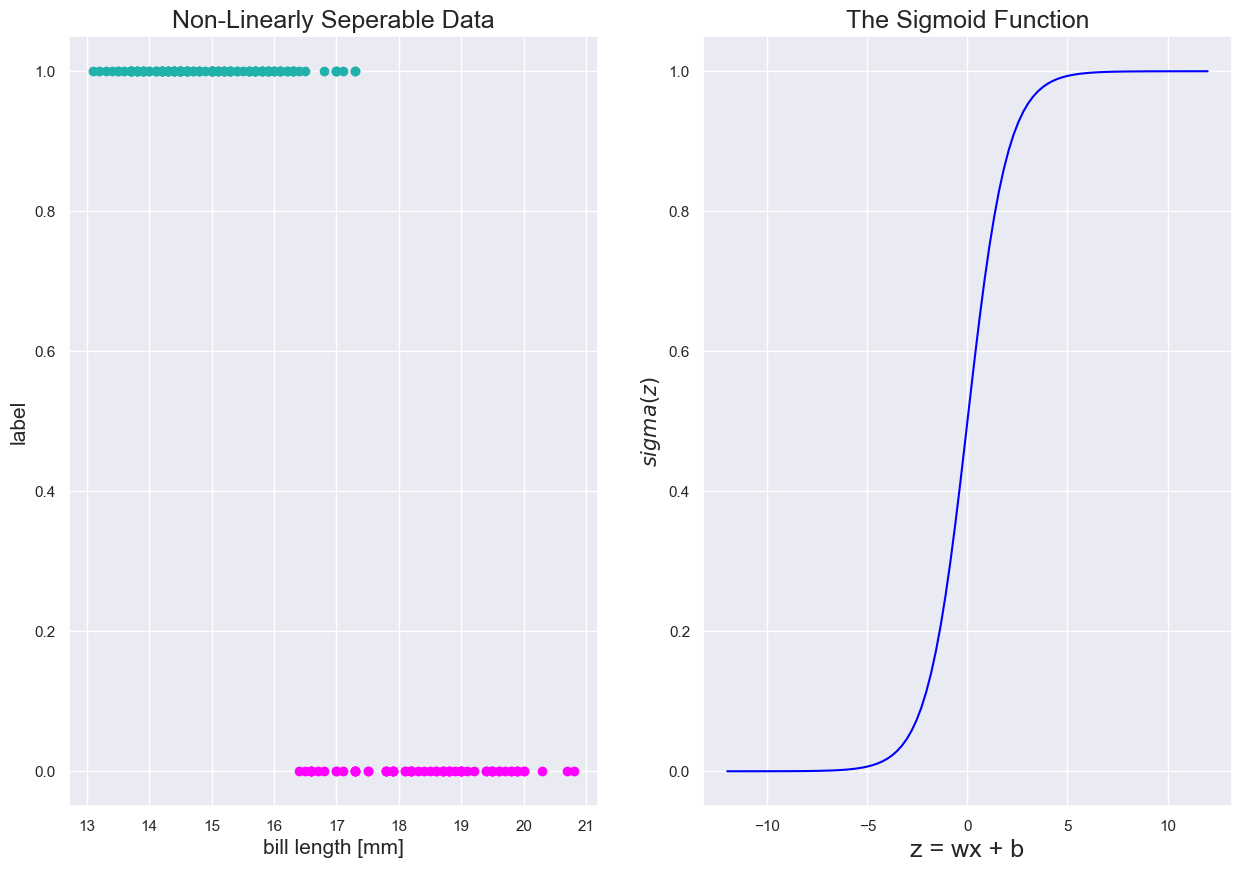

In [3]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.scatter(Chinstrap.bill_depth_mm, np.zeros(68), color = "magenta", label = "Chinstrap")
ax1.scatter(Gentoo.bill_depth_mm, np.ones(123), color = "lightseagreen", label = "Gentoo")
ax1.set_xlabel("bill length [mm]", fontsize = 15)
ax1.set_ylabel("label", fontsize = 15)
ax1.set_title("Non-Linearly Seperable Data", fontsize = 18)


domain = np.linspace(-12.0, 12.0, 100)
ax2.plot(domain, sigmoid(domain), color = "blue", label = "$\sigma$(z)")
ax2.set_xlabel("z = wx + b", fontsize = 18)
ax2.set_ylabel("$sigma(z)$", fontsize = 15)
ax2.set_title("The Sigmoid Function", fontsize = 18)
plt.show()

The binary cross entropy loss function will be used for this implementation, and its gradient will be calculated in order to optimize the logistic regression single neuron model with stochastic gradient descent similar to the two previous models.

In [ ]:
class SingleNeuron(object):
    """
    SingleNeuron model that learns using gradient descent with customizable activation and cost functions.

    This class represents a basic artificial neuron capable of learning a mapping from input features 
    to target outputs using a user-defined activation function (e.g., sigmoid, tanh) and cost function 
    (e.g., mean squared error). The model trains using gradient descent and supports visualization of 
    the training cost and decision boundary.

    Attributes:
        activation_function (callable): Function applied to the neuron's linear output (e.g., sigmoid).
        cost_function (callable): Function to compute the cost between predictions and true values.
        w_ (ndarray): Weight vector including the bias term.
        errors_ (list): Average cost for each epoch, tracked during training.

    Methods:
        train(X, y, alpha=0.005, epochs=50): Trains the neuron using gradient descent.
        predict(X): Returns the activated output for the input data.
        plot_cost_function(): Plots the cost value over training epochs.
        plot_decision_boundary(X, y, xstring="x", ystring="y"): Visualizes the learned decision boundary.
    """
    def __init__(self, activation_function, cost_function):
        self.activation_function = activation_function
        self.cost_function = cost_function

    def train(self, X, y, alpha = 0.005, epochs = 50):
        
        self.w_ = np.random.rand(1 + X.shape[1])
        self.errors_ = []
        N = X.shape[0]

        for _ in range(epochs):
            errors = 0
            for xi, target in zip(X, y):
                error = (self.predict(xi) - target)
                self.w_[:-1] -= alpha*error*xi
                self.w_[-1] -= alpha*error
                errors += self.cost_function(self.predict(xi), target)
            self.errors_.append(errors/N)
        return self

    def predict(self, X):
        preactivation = np.dot(X, self.w_[:-1]) + self.w_[-1]
        return self.activation_function(preactivation)

    def plot_cost_function(self):
        fig, axs = plt.subplots(figsize = (10, 8))
        axs.plot(range(1, len(self.errors_) + 1), self.errors_, label = "Cost function")
        axs.set_xlabel("epochs", fontsize = 15)
        axs.set_ylabel("Cost", fontsize = 15)
        axs.legend(fontsize = 15)
        axs.set_title("Cost Calculated after Epoch During Training", fontsize = 18)
        plt.show()

    def plot_decision_boundary(self, X, y, xstring="x", ystring="y"):
        plt.figure(figsize = (10, 8))
        plot_decision_regions(X, y, clf = self)
        plt.title("Neuron Decision Boundary", fontsize = 18)
        plt.xlabel(xstring, fontsize = 15)
        plt.ylabel(ystring, fontsize = 15)
        plt.show()

Before instantiating an instance of the ```SingleNeuron``` class, a function for the binary cross entropy loss must be written. Then an instance of our ```SingleNeuron``` can be created. Once our feature vector and target vector are created by converting the data to ```numpy.ndarray``` and reshaping, these values can then be passed into the ```SingleNeuron.train()``` method to train our logistic single neuron with stochastic gradient descent. Once the variable ```node``` has been trained, the binary cross entropy loss over each epoch can be visualized by plotting the values in the ```SingleNeuron.errors_``` attribute.

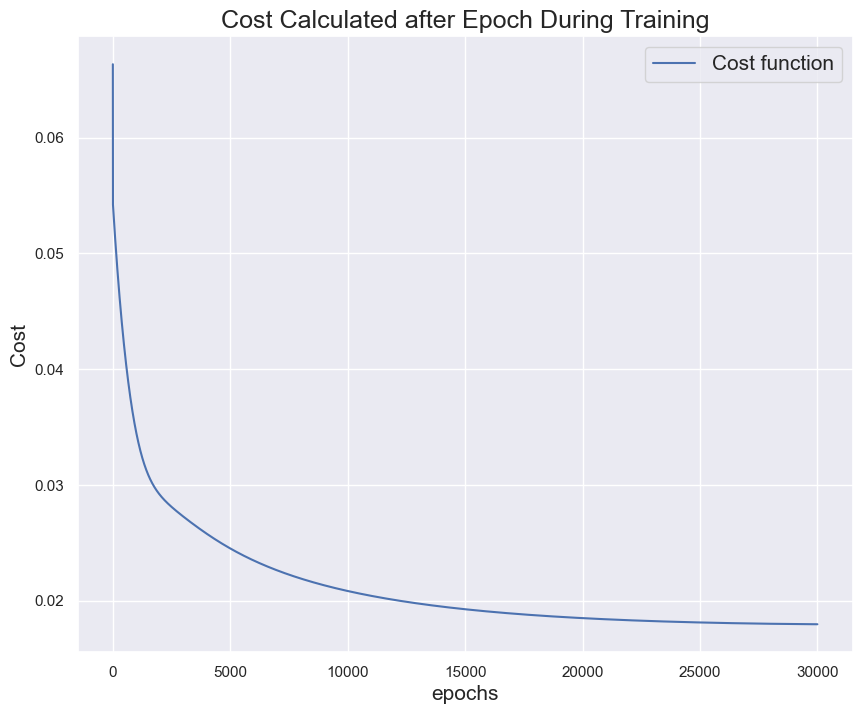

In [5]:
def cross_entropy_loss(y_hat, y):
    return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)

node = SingleNeuron(sigmoid, cross_entropy_loss)

X = df.iloc[151:].bill_depth_mm.values
X = X.reshape(-1, 1)
y = np.where(df.iloc[151:].species == "Chinstrap", 0, 1)

node.train(X, y, alpha = 0.01, epochs = 30_000)

node.plot_cost_function()
plt.show()

The prediction function can be visualized by plotting the ```SingleNeuron.predict()``` method over the scattered data points.

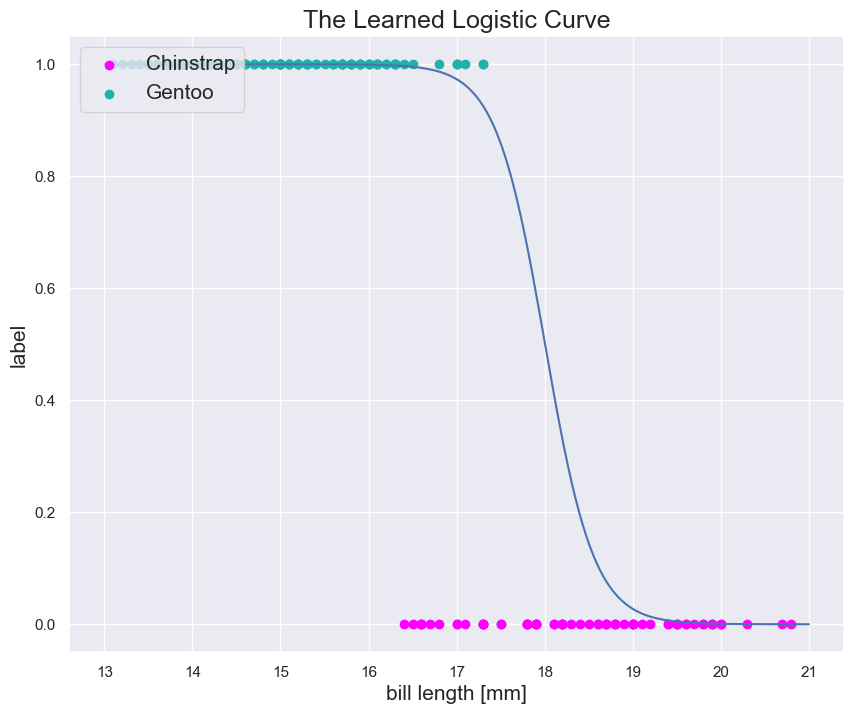

In [6]:
plt.figure(figsize = (10, 8))
plt.scatter(Chinstrap.bill_depth_mm, np.zeros(68), color = "magenta", label = "Chinstrap")
plt.scatter(Gentoo.bill_depth_mm, np.ones(123), color = "lightseagreen", label = "Gentoo")

domain = np.linspace(13, 21, 200)
plt.plot(domain, node.predict(domain.reshape(-1, 1)))
plt.xlabel("bill length [mm]", fontsize = 15)
plt.ylabel("label", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.title("The Learned Logistic Curve", fontsize = 18)
plt.show()

Now the classification error can be computed.

In [7]:
node.predict(X)

np.rint(node.predict(X)) != y

array([ True, False, False, False, False,  True, False, False, False,
       False,  True, False,  True, False,  True, False, False,  True,
       False, False,  True,  True,  True, False,  True, False, False,
       False,  True, False,  True, False,  True, False, False,  True,
       False, False,  True, False, False,  True, False,  True,  True,
       False,  True, False, False,  True,  True, False,  True, False,
        True, False,  True, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [8]:
classification_error = (np.rint(node.predict(X)) != y).astype(int)
print(f"Classification Error = {sum(classification_error)/ len(y)}")

Classification Error = 0.13612565445026178


Our decision boundary implied by the trained weights and bias can be visualized too.

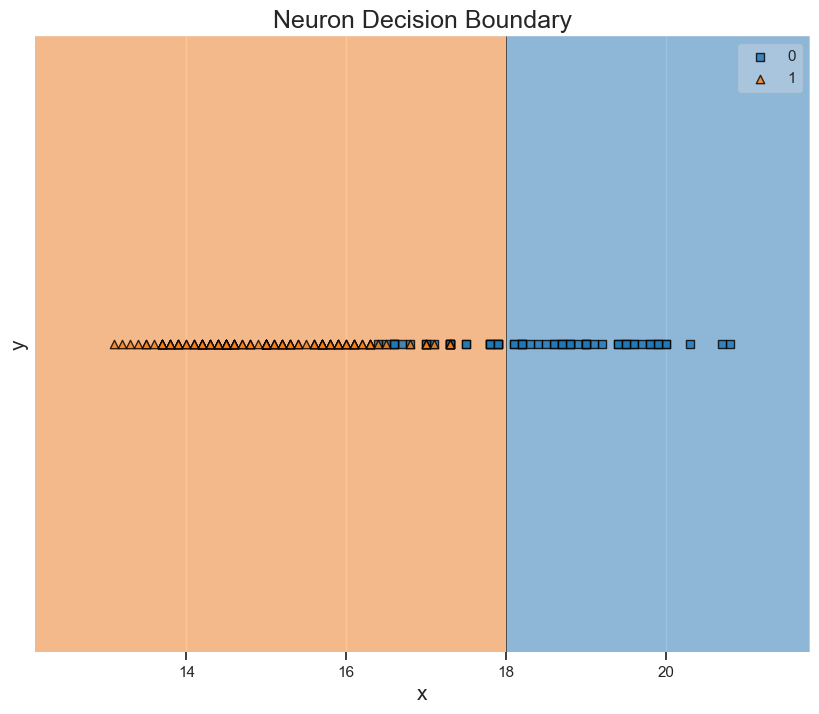

In [9]:
node.plot_decision_boundary(X, y)
plt.show()

Multiple feature measurements can be used by instantiating a ```SingleNeuron``` model with bill length and bill depth measurements as input. This model can be trained with the same learning rate and number of epochs as the variable ```node```, and then the cost function can be compared over epochs between the two models.

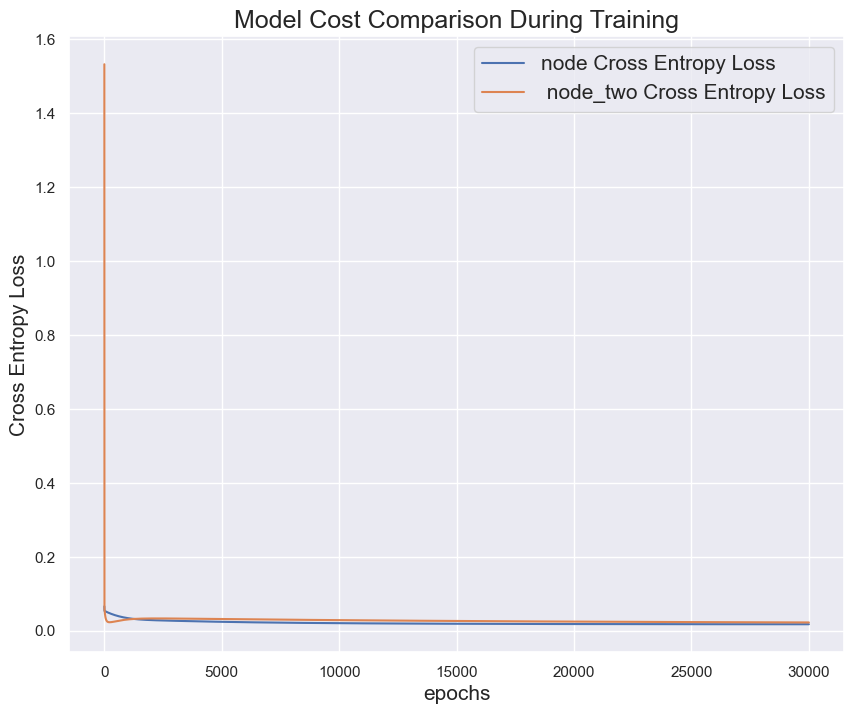

In [ ]:
# Instantiate a new single neuron.
node_two = SingleNeuron(sigmoid, cross_entropy_loss)

# Create a numpy.ndarray of bill length and bill depth values for the Chinstrap and Gentoo penguins. 
X_two = df.iloc[151:][["bill_length_mm", "bill_depth_mm"]].values

# Train the new single neuron model on the new feature vectors.
node_two.train(X_two, y, alpha = 0.001, epochs = 30_000)

plt.figure(figsize = (10, 8))
plt.plot(range(1, len(node.errors_) + 1), node.errors_, label = "node Cross Entropy Loss")
plt.plot(range(1, len(node_two.errors_) + 1), node_two.errors_, label = " node_two Cross Entropy Loss")
plt.xlabel("epochs", fontsize = 15)
plt.ylabel("Cross Entropy Loss", fontsize = 15)
plt.legend(fontsize = 15)
plt.title("Model Cost Comparison During Training", fontsize = 18)

plt.show()

The decision boundary generated by the trained weights and bias of ```node_two``` can be visualized.

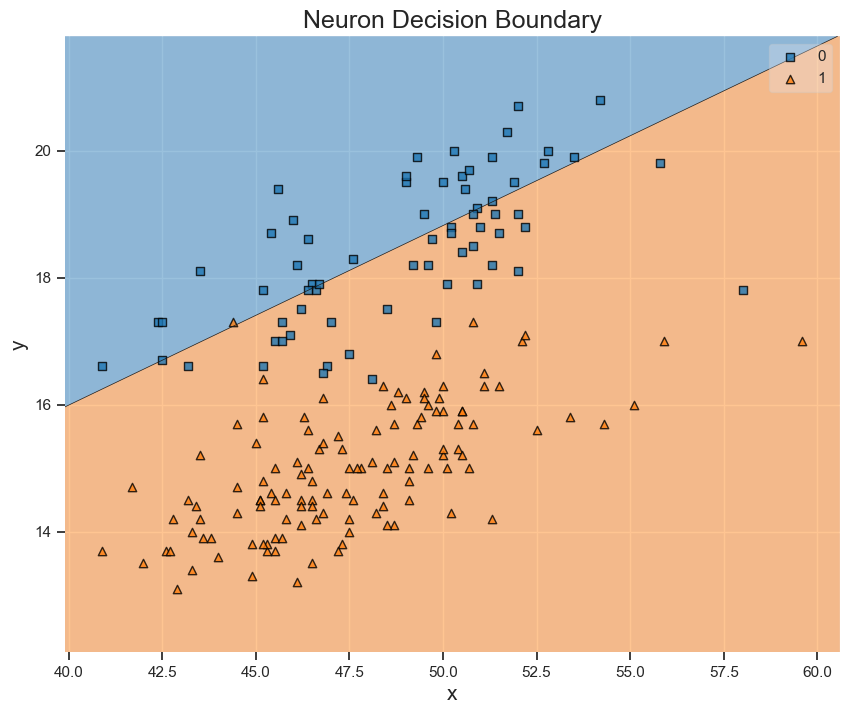

In [11]:
node_two.plot_decision_boundary(X_two, y)

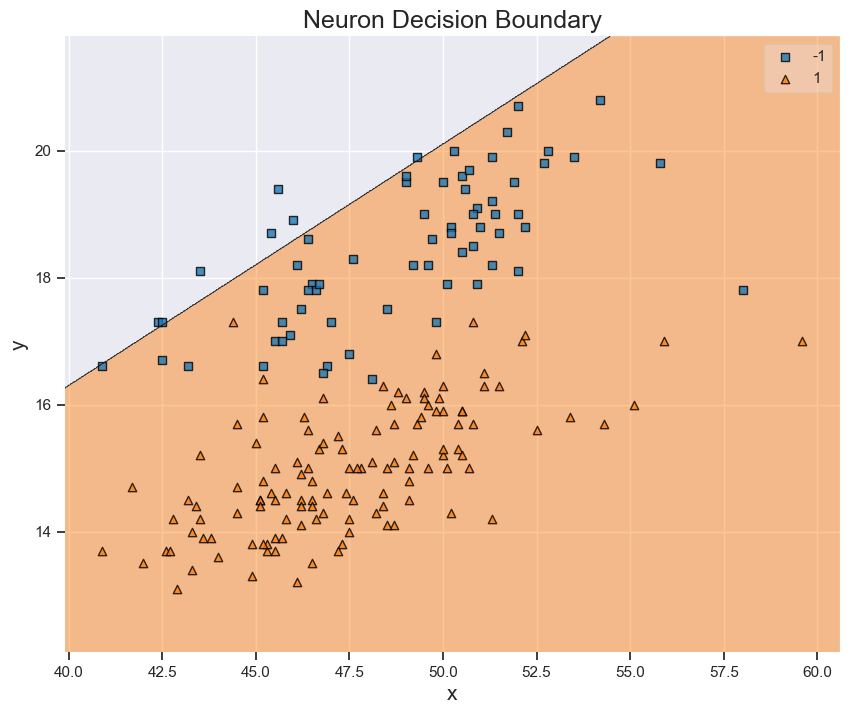

In [12]:
def sign(z):
    return np.sign(z)

def MSE(y_hat, y):
    return .5*(y_hat - y)**2

# Instantiate a new single neuron.
node_three = SingleNeuron(sign, MSE)

# Create a numpy.ndarray of bill length and bill depth values for the Chinstrap and Gentoo penguins. 
X_three = df.iloc[151:][["bill_length_mm", "bill_depth_mm"]].values

y_three = np.where(df.iloc[151:]["species"] == "Chinstrap", -1, 1)

# Train the new single neuron model on the new feature vectors.
node_three.train(X_three, y_three, alpha = 0.001, epochs = 5_000)

node_three.plot_decision_boundary(X_three, y_three)
plt.show()

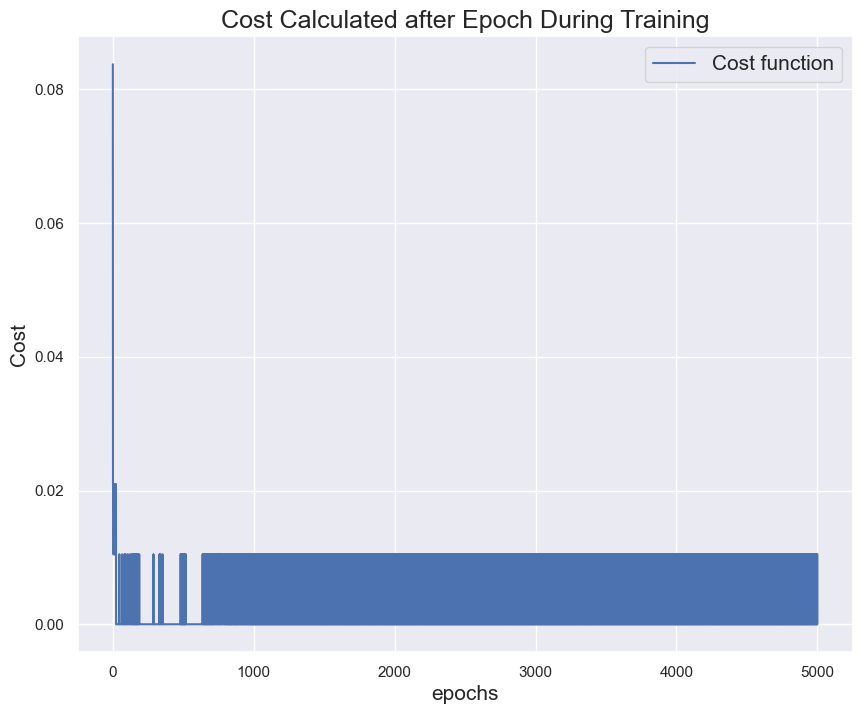

In [13]:
node_three.plot_cost_function()

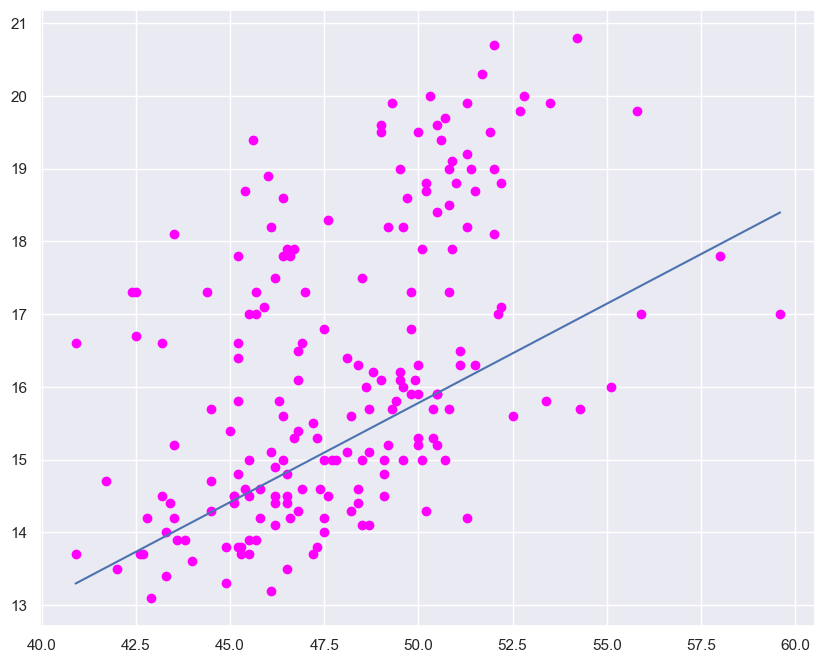

In [14]:
def linear(z):
    return z

# Instantiate a new single neuron.
node_four = SingleNeuron(linear, MSE)

# Create a numpy.ndarray of bill length and bill depth values for the Chinstrap and Gentoo penguins. 
X_four = df.iloc[151:]["bill_length_mm"].values
X_four = X_four.reshape(-1, 1)

y_four = df.iloc[151:]["bill_depth_mm"].values


# Train the new single neuron model on the new feature vectors.
node_four.train(X_four, y_four, alpha = 0.0001, epochs = 5_000)

plt.figure(figsize = (10, 8))
plt.scatter(X_four, y_four, label = "Chinstrap", color = "magenta")

domain = np.linspace(np.min(X_four), np.max(X_four), 50)
plt.plot(domain, node_four.predict(domain.reshape(-1, 1)), label = "regression line")
plt.show()

While the Cross Entropy Loss decreased for both ```node``` and ```node_two``` over epochs, my ```node_two``` did not perform better than node unlike in the example given in the lectures. Later on in these notebooks, I analyze the feature importance in the palmer_penguins dataset using Random Forests and Principal Component Analysis. I believe the reason my ```node_two``` did not perform as well as ```node``` is due to feature importance, and in this case, adding an additional feature actually worsened the performance of the model. This could also explain why my ```node_three``` cost function doesn't fully converge to zero.